In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from uncertainties import unumpy

def vfit_thomson_scattering_static(ods):
    """
    Set up static properties for Thomson scattering in the ODS object for VEST tokamak.

    This function populates the 'thomson_scattering' section of the given ODS object
    with static (time-independent) data such as positions and names of the channels.

    Parameters:
        ods (ODS): The OMAS data structure to populate.
    """
    ods['thomson_scattering.ids_properties.homogeneous_time'] = 1

    r_positions = [0.475, 0.425, 0.37, 0.31, 0.255]
    z_positions = [0, 0, 0, 0, 0]
    names = [
        'Polychrometer 1R1',
        'Polychrometer 2R2',
        'Polychrometer 3R3',
        'Polychrometer 4R4',
        'Polychrometer 5R5',
    ]

    for i in range(5):
        ods[f'thomson_scattering.channel.{i}.position.r'] = r_positions[i]
        ods[f'thomson_scattering.channel.{i}.position.z'] = z_positions[i]
        ods[f'thomson_scattering.channel.{i}.name'] = names[i]

def vfit_thomson_scattering_dynamic(ods, shotnumber, base_path=None):
    """
    Load dynamic Thomson scattering data from a .mat file into the ODS object for VEST tokamak.

    This function reads electron temperature and density data from a MATLAB .mat file
    for a given shot number and populates the 'thomson_scattering' section of the ODS.

    Parameters:
        ods (ODS): The OMAS data structure to populate.
        shotnumber (int): The shot number to load data for.
        base_path (str, optional): The base directory containing the data files.
            Defaults to the current working directory.
    """
    if base_path is None:
        base_path = os.getcwd()

    # find the file such that NeTe_Shot{shotnumber}*.mat
    pattern = f'NeTe_Shot{shotnumber}*.mat'
    for file in os.listdir(base_path):
        if pattern in file:
            filename = file
            print(f'Found file: {filename}')
            break
    filename_v10 = f'NeTe_Shot{shotnumber}_v10.mat'
    filename_v9_rev = f'NeTe_Shot{shotnumber}_v9_rev.mat'

    # 파일 존재 여부 확인
    if os.path.exists(filename_v10):
        filename = filename_v10
        version = 'v10'
    elif os.path.exists(filename_v9_rev):
        filename = filename_v9_rev
        version = 'v9_rev'
 
    mat_data = loadmat(os.path.join(base_path, filename))

    if 'dataset_description.data_entry.pulse' not in ods:
        ods['dataset_description.data_entry.pulse'] = shotnumber

    ods['thomson_scattering.time'] = mat_data['time_TS'][0] / 1e3  # Convert from ms to s

    for i in range(1, 6):  # Channels are numbered from 1 to 5
        channel_index = i - 1  # Indices in ods start from 0
        te_key = f'poly{i}R{i}_Te'
        te_sigma_key = f'poly{i}R{i}_sigmaTe'
        ne_key = f'poly{i}R{i}_Ne'
        ne_sigma_key = f'poly{i}R{i}_sigmaNe'

        # ods[f'thomson_scattering.channel.{channel_index}.t_e.data'] = unumpy.uarray(
        #     mat_data[te_key][0], mat_data[te_sigma_key][0]
        # )
        # ods[f'thomson_scattering.channel.{channel_index}.n_e.data'] = unumpy.uarray(
        #     mat_data[ne_key][0], mat_data[ne_sigma_key][0]
        # )
        ods[f'thomson_scattering.channel.{channel_index}.t_e.data'] = unumpy.uarray(
            mat_data[te_key][0],abs(mat_data[te_sigma_key][0])
        )
        ods[f'thomson_scattering.channel.{channel_index}.n_e.data'] = unumpy.uarray(
            mat_data[ne_key][0],abs(mat_data[ne_sigma_key][0])
        )
        # ad-hoc Ne, Te sigma as absolute value

def equilibrium_mapping_thomson_scattering(ods, geq):
    """
    Map Thomson scattering positions to normalized poloidal flux coordinates (rho).

    This function finds the closest flux surface for each Thomson scattering measurement point
    and maps it to the corresponding normalized poloidal flux value (rho) in the equilibrium data.

    Parameters:
        ods (ODS): The OMAS data structure containing Thomson scattering positions.
        geq (dict): The equilibrium data containing flux surfaces and levels.

    Returns:
        numpy.ndarray: An array of mapped rho positions for each Thomson scattering point.
    """
    # Extract Thomson scattering positions
    r_t = ods['thomson_scattering.channel.:.position.r']
    z_t = ods['thomson_scattering.channel.:.position.z']

    # Extract flux surface levels (normalized poloidal flux values)
    flux_levels = geq['fluxSurfaces']['levels']

    # Initialize list to store mapped rho positions
    mapped_rho_position = []

    # For each Thomson scattering point, find the closest flux surface
    for r_dot, z_dot in zip(r_t, z_t):
        min_dist = float('inf')
        closest_rho = None

        # Iterate over all flux surfaces
        for i in range(len(geq['fluxSurfaces']['flux'])):
            R = geq['fluxSurfaces']['flux'][i]['R']
            Z = geq['fluxSurfaces']['flux'][i]['Z']

            # Compute distances to all points on this flux surface
            dists = np.sqrt((R - r_dot) ** 2 + (Z - z_dot) ** 2)
            min_flux_dist = np.min(dists)

            if min_flux_dist < min_dist:
                min_dist = min_flux_dist
                closest_rho = flux_levels[i]  # Normalized poloidal flux value

        mapped_rho_position.append(closest_rho)

    # Convert to numpy array
    mapped_rho_position = np.array(mapped_rho_position)

    # Ensure rho values are within [0, 1]
    mapped_rho_position = np.clip(mapped_rho_position, 0, 1)

    return mapped_rho_position

def profile_fitting_thomson_scattering(
    ods,
    time_ms,
    mapped_rho_position,
    Te_order,
    Ne_order,
    uncertainty_option=1,
    rho_points=100,
    fitting_function_opt='polynomial',
):
    """
    Fit electron temperature and density profiles from Thomson scattering data.

    This function fits the electron temperature (Te) and electron density (Ne) profiles
    using the specified fitting function (polynomial or exponential) at a given time.
    The fitted profiles are functions of normalized poloidal flux (rho).

    Parameters:
        ods (ODS): The OMAS data structure containing Thomson scattering data.
        time_ms (float): The time (in milliseconds) at which to extract data and fit profiles.
        mapped_rho_position (array-like): The mapped rho positions for each Thomson scattering point.
        Te_order (int): The order of the polynomial/exponential function for Te fitting.
        Ne_order (int): The order of the polynomial/exponential function for Ne fitting.
        uncertainty_option (int, optional): If 1, include uncertainties in the fit;
            else, ignore uncertainties.
        rho_points (int, optional): Number of rho points to evaluate the fitted profiles.
        fitting_function_opt (str, optional): Type of fitting function ('polynomial' or 'exponential').

    Returns:
        tuple: A tuple containing:
            - n_e_function (callable): Function to compute fitted electron density at any rho.
            - T_e_function (callable): Function to compute fitted electron temperature at any rho.
            - coeffs_ne (numpy.ndarray): Coefficients of the fitted Ne function.
            - coeffs_te (numpy.ndarray): Coefficients of the fitted Te function.
            - n_e_rho (numpy.ndarray): Fitted Ne values at evaluated rho points.
            - T_e_rho (numpy.ndarray): Fitted Te values at evaluated rho points.
    """
    from scipy.optimize import curve_fit

    # Extract data and uncertainties
    t_e = []
    n_e = []
    t_e_std = []
    n_e_std = []

    # Find time index for the specific time
    time_index = np.where(ods['thomson_scattering.time'] == (time_ms) / 1e3)[0][0]

    num_channels = len(ods['thomson_scattering.channel'])
    for i in range(num_channels):
        channel = ods['thomson_scattering.channel'][i]
        t_e_data = channel['t_e.data'][time_index]
        n_e_data = channel['n_e.data'][time_index]
        t_e_error = channel['t_e.data_error_upper'][time_index]
        n_e_error = channel['n_e.data_error_upper'][time_index]
        t_e.append(t_e_data)
        n_e.append(n_e_data)
        t_e_std.append(t_e_error)
        n_e_std.append(n_e_error)

    # Convert to numpy arrays
    t_e = np.array(t_e)
    n_e = np.array(n_e)
    t_e_std = np.array(t_e_std)
    n_e_std = np.array(n_e_std)
    rho = np.array(mapped_rho_position)

    # Ensure rho is within [0, 1]
    rho = np.clip(rho, 0, 1)

    # Normalize n_e data and uncertainties if necessary
    n_e_scale = 1e18
    n_e_norm = n_e / n_e_scale
    n_e_std_norm = n_e_std / n_e_scale

    # Define the fitting function with boundary condition at rho=1
    if fitting_function_opt == 'polynomial':
        def fitting_function(x, *coeffs):
            s = sum([coeffs[k] * x ** k for k in range(len(coeffs))])
            return (1 - x) * s

    elif fitting_function_opt == 'exponential':
        def fitting_function(x, *coeffs):
            s = sum([coeffs[k] * x ** k for k in range(len(coeffs))])
            return (1 - x) * np.exp(s)

    else:
        raise ValueError(f"Invalid fitting_function_opt: {fitting_function_opt}")

    # Prepare rho points for evaluating the profiles
    rho_eval = np.linspace(0, 1, rho_points)

    # Fit T_e profile
    initial_guess_te = np.ones(Te_order) * 0.1  # Start with small non-zero values
    if uncertainty_option == 1:  # Consider uncertainties in the fit
        coeffs_te, cov_te = curve_fit(
            fitting_function,
            rho,
            t_e,
            sigma=t_e_std,
            absolute_sigma=True,
            p0=initial_guess_te,
        )
    else:  # Do not consider uncertainties in the fit
        coeffs_te, cov_te = curve_fit(
            fitting_function,
            rho,
            t_e,
            p0=initial_guess_te,
        )
    T_e_rho = fitting_function(rho_eval, *coeffs_te)

    # Create T_e_function
    def T_e_function(rho_input):
        rho_input = np.clip(rho_input, 0, 1)
        return fitting_function(rho_input, *coeffs_te)

    # Fit n_e profile (on normalized data)
    initial_guess_ne = np.ones(Ne_order) * 0.1
    if uncertainty_option == 1:
        coeffs_ne, cov_ne = curve_fit(
            fitting_function,
            rho,
            n_e_norm,
            sigma=n_e_std_norm,
            absolute_sigma=True,
            p0=initial_guess_ne,
        )
    else:
        coeffs_ne, cov_ne = curve_fit(
            fitting_function,
            rho,
            n_e_norm,
            p0=initial_guess_ne,
        )
    n_e_rho_norm = fitting_function(rho_eval, *coeffs_ne)

    # Scale back the fitted n_e profile to original units
    n_e_rho = n_e_rho_norm * n_e_scale

    # Create n_e_function
    def n_e_function(rho_input):
        rho_input = np.clip(rho_input, 0, 1)
        n_e_norm_output = fitting_function(rho_input, *coeffs_ne)
        return n_e_norm_output * n_e_scale

    return n_e_function, T_e_function, coeffs_ne, coeffs_te, n_e_rho, T_e_rho

def plot_electron_profile_with_thomson(
    ods,
    time_ms,
    mapped_rho_position,
    n_e_function,
    T_e_function,
    n_e_coeff,
    T_e_coeff,
    save_opt = 1
):
    """
    Plot the core electron temperature and density profiles along with Thomson scattering data.

    This function plots the fitted electron temperature and density profiles as functions
    of normalized poloidal flux (rho), and overlays the measured Thomson scattering data
    with error bars.

    Parameters:
        ods (ODS): The OMAS data structure containing Thomson scattering data.
        time_ms (float): The time (in milliseconds) at which to extract data for plotting.
        mapped_rho_position (array-like): The mapped rho positions for each Thomson scattering point.
        n_e_function (callable): Function to compute fitted electron density at any rho.
        T_e_function (callable): Function to compute fitted electron temperature at any rho.
        n_e_coeff (numpy.ndarray): Coefficients of the fitted Ne function (unused in this function).
        T_e_coeff (numpy.ndarray): Coefficients of the fitted Te function (unused in this function).
    """
    # Extract data at specific time
    t_e = []
    n_e = []
    t_e_data_error_upper = []
    n_e_data_error_upper = []

    # Extract shotnumber
    shotnumber = ods['dataset_description.data_entry.pulse']

    time_index = np.where(ods['thomson_scattering.time'] == time_ms / 1e3)[0][0]

    num_channels = len(ods['thomson_scattering.channel'])
    for i in range(num_channels):
        t_e.append(ods['thomson_scattering.channel'][i]['t_e.data'][time_index])
        n_e.append(ods['thomson_scattering.channel'][i]['n_e.data'][time_index])
        t_e_data_error_upper.append(
            ods['thomson_scattering.channel'][i]['t_e.data_error_upper'][time_index]
        )
        n_e_data_error_upper.append(
            ods['thomson_scattering.channel'][i]['n_e.data_error_upper'][time_index]
        )

    # Convert to numpy arrays for consistency
    t_e = np.array(t_e)
    n_e = np.array(n_e)
    t_e_data_error_upper = np.array(t_e_data_error_upper)
    n_e_data_error_upper = np.array(n_e_data_error_upper)

    # Plot the core profiles
    rho_eval = np.linspace(0, 1, 100)
    fig, axs = plt.subplots(2, 1, figsize=(6, 6))

    axs[0].errorbar(
        mapped_rho_position,
        t_e,
        yerr=t_e_data_error_upper,
        fmt='o',
        label='Measured Te with uncertainty',
    )
    axs[0].plot(rho_eval, T_e_function(rho_eval), label='Fitted Te')
    axs[0].set_xlabel(r'$\psi_N$')
    axs[0].set_ylabel(r'$T_e$ (eV)')
    axs[0].set_title(f'shot = {shotnumber}, time = {time_ms} ms\nElectron Temperature Profile')
    axs[0].legend()

    axs[1].errorbar(
        mapped_rho_position,
        n_e,
        yerr=n_e_data_error_upper,
        fmt='o',
        label='Measured Ne with uncertainty',
    )
    axs[1].plot(rho_eval, n_e_function(rho_eval), label='Fitted Ne')
    axs[1].set_xlabel(r'$\psi_N$')
    axs[1].set_ylabel(r'$n_e$ (m$^{-3}$)')
    axs[1].set_title('Electron Density Profile')
    axs[1].legend()

    plt.tight_layout()

    if save_opt == 1:
        plt.savefig(f'thomson_scattering_profiles_{shotnumber}_{time_ms}.png')
    plt.show()

def export_electron_profile_txt(
    n_e_function,
    T_e_function,
    n_e_coeff,
    T_e_coeff,
    rho_points=100,
    filename='electron_profiles.txt',
):
    """
    Export the fitted electron temperature and density profiles to a text file.

    This function evaluates the fitted electron temperature and density profiles at
    a specified number of rho points and exports the results to a text file.

    Parameters:
        n_e_function (callable): Function to compute fitted electron density at any rho.
        T_e_function (callable): Function to compute fitted electron temperature at any rho.
        n_e_coeff (numpy.ndarray): Coefficients of the fitted Ne function.
        T_e_coeff (numpy.ndarray): Coefficients of the fitted Te function.
        rho_points (int, optional): Number of rho points to evaluate the fitted profiles.
        filename (str, optional): The name of the text file to save the profiles to.
    """
    rho_eval = np.linspace(0, 1, rho_points)
    n_e_rho = n_e_function(rho_eval)
    T_e_rho = T_e_function(rho_eval)

    with open(filename, 'w') as f:
        f.write('psi_N, T_e [eV], n_e [m-3]\n')
        for rho, T_e, n_e in zip(rho_eval, T_e_rho, n_e_rho):
            f.write(f'{rho}, {T_e}, {n_e}\n')


In [11]:
# print(OMFITgeq.keys())

# ods = OMFITgeq.to_omas()
print(ods.cocos)

11


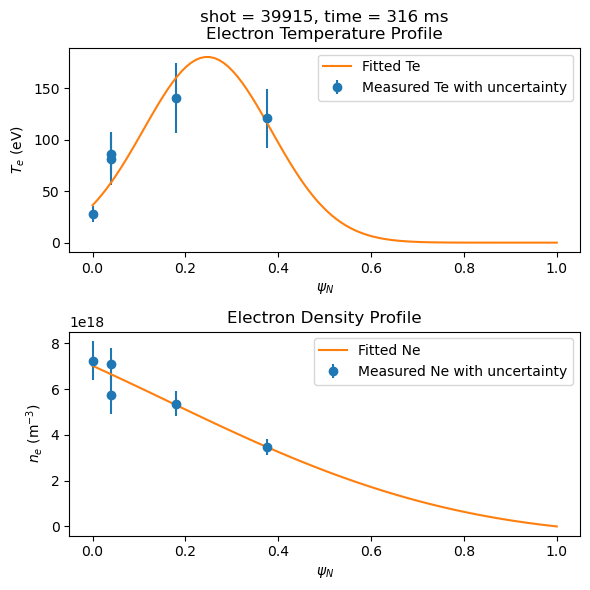

In [13]:
# Load your ODS and equilibrium data
from omas import *
from omfit_classes.omfit_eqdsk import OMFITgeqdsk


# Set fitting parameters
Te_order = 3  # Degree of the polynomial for T_e fitting
Ne_order = 3  # Degree of the polynomial for n_e fitting
uncertainty_option = True  # Include uncertainties in fitting
rho_points = 101  # Number of points in rho to evaluate the profiles


time_ms = [316]

ods = ODS()
shot = 39915

vfit_thomson_scattering_static(ods)
vfit_thomson_scattering_dynamic(ods, shot)

for i, time_ms in enumerate(time_ms):
    # Load equilibrium data
    geq_filename = 'g0{}.00{}'.format(shot, time_ms)
    OMFITgeq = OMFITgeqdsk(filename=geq_filename)

    # Map Thomson scattering positions onto equilibrium
    mapped_rho_position = equilibrium_mapping_thomson_scattering(ods, OMFITgeq)

    # Perform profile fitting
    n_e_function, T_e_function, n_e_coeff, T_e_coeff, n_e_rho, T_e_rho = profile_fitting_thomson_scattering(
        ods,
        time_ms,
        mapped_rho_position,
        Te_order,
        Ne_order,
        uncertainty_option,
        rho_points,
        # fitting_function_opt='polynomial'
        fitting_function_opt='exponential'
    )

    plot_electron_profile_with_thomson(ods, time_ms, mapped_rho_position, n_e_function, T_e_function, n_e_coeff, T_e_coeff)

    export_electron_profile_txt(
        n_e_function,
        T_e_function,
        n_e_coeff,
        T_e_coeff,
        rho_points=401,
        # filename=f'{shot}_{time_ms}_electron_profiles_polynomial_fit.txt',
        filename=f'{shot}_{time_ms}_electron_profiles_exponential_fit.txt',
    )

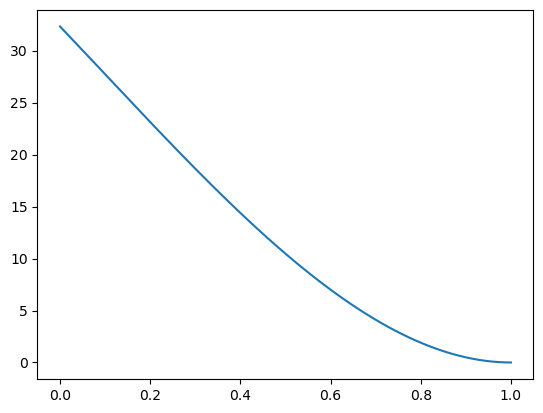

In [14]:

psi = np.zeros(len(OMFITgeq['fluxSurfaces']['flux']))
psi_N = np.zeros(len(OMFITgeq['fluxSurfaces']['flux']))
p = np.zeros(len(OMFITgeq['fluxSurfaces']['flux']))
for i in range(len(OMFITgeq['fluxSurfaces']['flux'])):
    psi[i] = OMFITgeq['fluxSurfaces']['flux'][i]['psi']
    p[i] = OMFITgeq['fluxSurfaces']['flux'][i]['p']

psi_N = (psi - psi[0]) / (psi[-1] - psi[0])

plt.plot(psi_N, p)



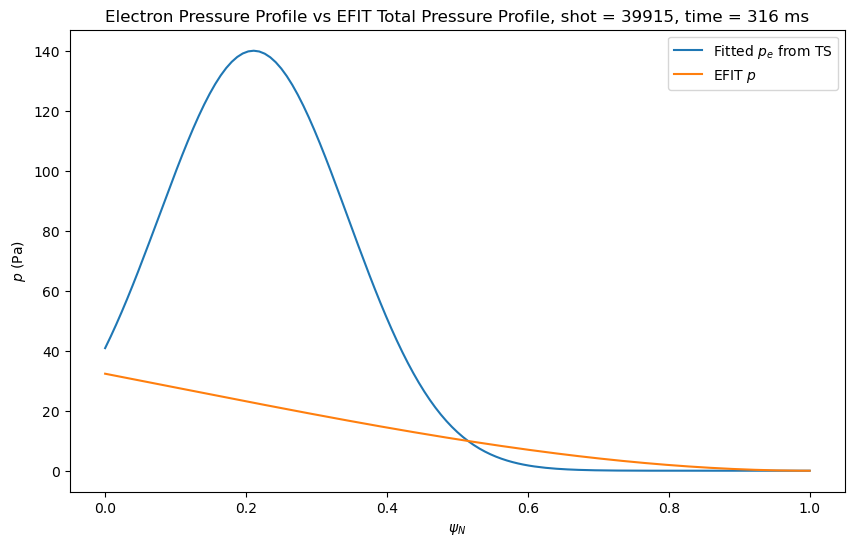

In [15]:

def plot_pressure_profile_with_geqdsk(shot, time_ms, n_e_function, T_e_function, geqdsk, save_opt = 1):
    """
    Plot the core electron temperature and density profiles along with the pressure profile from GEQDSK.

    This function plots the fitted electron temperature and density profiles as functions
    of normalized poloidal flux (rho), and overlays the pressure profile from GEQDSK.

    Parameters:
        n_e_function (callable): Function to compute fitted electron density at any rho.
        T_e_function (callable): Function to compute fitted electron temperature at any rho.
        geqdsk (dict): The GEQDSK equilibrium data containing pressure profiles.
    """
    # Extract pressure profile from GEQDSK
    psi = np.zeros(len(geqdsk['fluxSurfaces']['flux']))
    psi_N = np.zeros(len(geqdsk['fluxSurfaces']['flux']))
    pressure = np.zeros(len(geqdsk['fluxSurfaces']['flux']))

    for i in range(len(OMFITgeq['fluxSurfaces']['flux'])):
        psi[i] = OMFITgeq['fluxSurfaces']['flux'][i]['psi']
        pressure[i] = OMFITgeq['fluxSurfaces']['flux'][i]['p']
    psi_N = (psi - psi[0]) / (psi[-1] - psi[0])

    # Evaluate the fitted profiles at the same rho points
    T_e_rho = T_e_function(psi_N)
    n_e_rho = n_e_function(psi_N)

    # Calculate electron pressure from fitted profiles
    p_e_rho = n_e_rho * T_e_rho * 1.602e-19  # Convert to Pa

    # Plot the core profiles
    plt.figure(figsize=(10, 6))
    plt.plot(psi_N, p_e_rho, label='Fitted $p_e$ from TS')
    plt.plot(psi_N, pressure, label='EFIT $p$')
    plt.xlabel(r'$\psi_N$')
    plt.ylabel(r'$p$ (Pa)')
    plt.title('Electron Pressure Profile vs EFIT Total Pressure Profile, shot = {}, time = {} ms'.format(shot, time_ms))
    plt.legend()

    if save_opt == 1:
        plt.savefig(f'pressure_profile_comparison_{shot}_{time_ms}.png')


OMFITgeq = OMFITgeqdsk(f'g0{shot}.00{time_ms}')
plot_pressure_profile_with_geqdsk(shot, time_ms, n_e_function, T_e_function, OMFITgeq, save_opt = 1)

In [15]:

filename_v10 = f'NeTe_Shot41518_v10.mat'
filename_v9_rev = f'NeTe_Shot39915_v9_rev.mat'
base_path = os.getcwd()
mat_v10 = loadmat(os.path.join(base_path, filename_v10))
mat_v9_rev = loadmat(os.path.join(base_path, filename_v9_rev))



In [16]:
print(mat_v10['time_TS'][0])   
print(mat_v9_rev.keys())


[317 318 319 320 321 322 323 324 325 326]
dict_keys(['__header__', '__version__', '__globals__', 'time_TS', 'poly1_noise_level', 'poly2_noise_level', 'poly3_noise_level', 'poly4_noise_level', 'poly5_noise_level', 'poly1R1_Te', 'poly1R1_Ne', 'poly1R1_Ne_under', 'poly1R1_Ne_upper', 'poly1R1_Te_under', 'poly1R1_Te_upper', 'poly1R1_sigmaTe', 'poly1R1_sigmaNe', 'poly2R2_Te', 'poly2R2_Ne', 'poly2R2_Ne_under', 'poly2R2_Ne_upper', 'poly2R2_Te_under', 'poly2R2_Te_upper', 'poly2R2_sigmaTe', 'poly2R2_sigmaNe', 'poly3R3_Te', 'poly3R3_Ne', 'poly3R3_Ne_under', 'poly3R3_Ne_upper', 'poly3R3_Te_under', 'poly3R3_Te_upper', 'poly3R3_sigmaTe', 'poly3R3_sigmaNe', 'poly4R4_Te', 'poly4R4_Ne', 'poly4R4_Ne_under', 'poly4R4_Ne_upper', 'poly4R4_Te_under', 'poly4R4_Te_upper', 'poly4R4_sigmaTe', 'poly4R4_sigmaNe', 'poly5R5_Te', 'poly5R5_Ne', 'poly5R5_sigmaTe', 'poly5R5_sigmaNe', 'poly5R5_Ne_under', 'poly5R5_Te_under', 'poly5R5_Ne_upper', 'poly5R5_Te_upper', 'minimum_chi2'])


In [17]:
p

array([3.07539401e+01, 3.04148844e+01, 3.00752032e+01, 2.97349487e+01,
       2.93941726e+01, 2.90529269e+01, 2.87112635e+01, 2.83692344e+01,
       2.80268916e+01, 2.76842868e+01, 2.73414722e+01, 2.69984995e+01,
       2.66554208e+01, 2.63122879e+01, 2.59691529e+01, 2.56260675e+01,
       2.52830838e+01, 2.49402538e+01, 2.45976292e+01, 2.42552621e+01,
       2.39132044e+01, 2.35715080e+01, 2.32302249e+01, 2.28894070e+01,
       2.25491062e+01, 2.22093744e+01, 2.18702636e+01, 2.15318257e+01,
       2.11941127e+01, 2.08571764e+01, 2.05210689e+01, 2.01858420e+01,
       1.98515477e+01, 1.95182378e+01, 1.91859645e+01, 1.88547794e+01,
       1.85247347e+01, 1.81958822e+01, 1.78682739e+01, 1.75419617e+01,
       1.72169975e+01, 1.68934333e+01, 1.65713210e+01, 1.62507125e+01,
       1.59316597e+01, 1.56142146e+01, 1.52984292e+01, 1.49843553e+01,
       1.46720449e+01, 1.43615499e+01, 1.40529223e+01, 1.37462139e+01,
       1.34414768e+01, 1.31387628e+01, 1.28381239e+01, 1.25396120e+01,
      

In [18]:
def confinement_time_scaling(Ip, R0, eps, kappa, n_e, B0, M, P):
    """
    Confinement time scaling for H98y2 (ITER98(y,2) H mode).
    """
    # Convert units
    Ip = Ip * 1e-6  # [A] -> [MA]
    P = P * 1e-6    # [W] -> [MW]
    n_e = n_e * 1e-20  # [m^-3] -> [1E20 m^-3]

    tau_e = 0.0562 * Ip**0.93 * B0**0.15 * P**-0.69 * n_e**0.42 * M**0.19 * R0**1.97 * eps**0.58 * kappa**0.78
        
    return tau_e

def greenwald_density(ip, a):
    """
    Compute the Greenwald density profile based on the plasma current.

    Parameters:
    """
    ip = ip * 1e-6  # [A] -> [MA]
    return 1e20 * ip / (np.pi * a**2)



# # KSTAR Design Value [Lee GS, NF 41 10 (2001)]
KSTAR = {}
KSTAR['Ip'] = 2e6  # Plasma current [A]
KSTAR['R0'] = 1.8  # Major radius [m]
KSTAR['eps'] = 0.5  # Inverse aspect ratio
KSTAR['kappa'] = 1.8  # Elongation
KSTAR['n_e'] = greenwald_density(KSTAR['Ip'], KSTAR['R0']*KSTAR['eps'])  # Greenwald density
KSTAR['B0'] = 3.5  # Toroidal field [T]
KSTAR['M'] = 2  # Mass number
KSTAR['P'] = 16e6  # Heating power [W]

# ITER Design Value [R Aymar, PPCF 44 5 (2002): 519]
ITER = {}
ITER['Ip'] = 15e6  # Plasma current [A]
ITER['R0'] = 6.2  # Major radius [m]
ITER['eps'] = 2 / 6.2  # Inverse aspect ratio
ITER['kappa'] = 1.85  # Elongation
ITER['n_e'] = greenwald_density(ITER['Ip'], ITER['R0']*ITER['eps'])  # Greenwald density
ITER['B0'] = 5.3  # Toroidal field [T]
ITER['M'] = 2.5  # Mass number
ITER['P'] = 73e6  # Heating power [W]

# Calculate confinement time scaling for KSTAR and ITER
tau_KSTAR = confinement_time_scaling(**KSTAR)
tau_ITER = confinement_time_scaling(**ITER)

print(f"Confinement time scaling for KSTAR: {tau_KSTAR:.2f} s")
print(f"Confinement time scaling for ITER: {tau_ITER:.2f} s")


Confinement time scaling for KSTAR: 0.07 s
Confinement time scaling for ITER: 1.81 s


In [19]:
# Define variables
IPB98y2 = (0.93, 0.15, -0.69, 0.41, 0.19, 1.97, 0.58, 0.78)

# Engineering to dimensionless physics equations
def engineering_to_dimensionless(alpha_I, alpha_B, alpha_P, alpha_n, alpha_M, alpha_R, alpha_epsilon, alpha_kappa):
    x_omega_eq = (alpha_B + 0.2*alpha_I + 1.6*alpha_n - 0.4*alpha_P - 0.8*alpha_R) / (1 + alpha_P)
    x_rho_star_eq = (-1.2*alpha_I + 0.4*alpha_n - 3.6*alpha_P - 1.2*alpha_R) / (1 + alpha_P)
    x_nu_star_eq = (-0.2*alpha_I + 0.4*alpha_n - 0.6*alpha_P - 0.2*alpha_R) / (1 + alpha_P)
    x_beta_eq = (0.2*alpha_I + 0.6*alpha_n + 1.6*alpha_P + 0.2*alpha_R) / (1 + alpha_P)
    x_M_eq = (alpha_B + 0.8*alpha_I + alpha_M + 1.4*alpha_n + 1.4*alpha_P - 0.2*alpha_R) / (1 + alpha_P)
    x_q_eq = (-0.8*alpha_I - 0.4*alpha_n + 0.6*alpha_P + 0.2*alpha_R) / (1 + alpha_P)
    x_epsilon_eq = (alpha_epsilon + 0.5*alpha_I + alpha_n - 2.5*alpha_P - 1.5*alpha_R) / (1 + alpha_P)
    x_kappa_eq = (alpha_I + alpha_kappa + alpha_P) / (1 + alpha_P)
    
    return x_omega_eq, x_rho_star_eq, x_nu_star_eq, x_beta_eq, x_M_eq, x_q_eq, x_epsilon_eq, x_kappa_eq

# Test functions
eng_to_dim = engineering_to_dimensionless(*IPB98y2)

print(f"Dimensionless physics parameters: {tuple(f'{x:.3f}' for x in eng_to_dim)}")
    

Dimensionless physics parameters: ('-0.994', '-2.684', '-0.006', '-0.897', '0.961', '-2.994', '0.726', '3.290')


In [20]:

# Dimensionless physics to engineering equations
def dimensionless_to_engineering(x_omega, x_rho_star, x_nu_star, x_beta, x_M, x_q, x_epsilon, x_kappa):
    alpha_I_eq = (-x_nu_star - x_q) / (1 - 0.5*x_rho_star + 2*x_nu_star - x_beta)
    alpha_P_eq = (0.5*x_rho_star - 2*x_nu_star + x_beta) / (1 - 0.5*x_rho_star + 2*x_nu_star - x_beta)
    alpha_A_eq = (-x_omega + 0.5*x_rho_star + x_M) / (1 - 0.5*x_rho_star + 2*x_nu_star - x_beta)
    alpha_epsilon_eq = (-2*x_rho_star + 4.5*x_nu_star - 2*x_beta + 2*x_q + x_epsilon) / (1 - 0.5*x_rho_star + 2*x_nu_star - x_beta)
    alpha_R_eq = (-2.5*x_rho_star + 8*x_nu_star - 3*x_beta + x_q) / (1 - 0.5*x_rho_star + 2*x_nu_star - x_beta)
    alpha_B_eq = (x_omega - x_rho_star + x_nu_star - 2*x_beta + x_q) / (1 - 0.5*x_rho_star + 2*x_nu_star - x_beta)
    alpha_n_eq = (-0.5*x_rho_star + 3*x_nu_star) / (1 - 0.5*x_rho_star + 2*x_nu_star - x_beta)
    alpha_kappa_eq = (3*x_nu_star - 0.5*x_rho_star - x_beta + x_q + x_kappa) / (1 - 0.5*x_rho_star + 2*x_nu_star - x_beta)
    
    return alpha_I_eq, alpha_P_eq, alpha_A_eq, alpha_epsilon_eq, alpha_R_eq, alpha_B_eq, alpha_n_eq, alpha_kappa_eq
